<a href="https://colab.research.google.com/github/eshal26/Convolutional-Neural-Networks/blob/main/ROC_and_PR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])


# Path to your dataset in Google Drive
dataset_path = 'test_dataset'

# Load the dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

# Create a DataLoader
test_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate through the DataLoader
for images, labels in test_loader:
    print(images.size(), labels.size())
    break


torch.Size([32, 3, 224, 224]) torch.Size([32])


In [13]:
import torch
import torch.nn as nn
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class SimplifiedXception(nn.Module):
    def __init__(self, num_classes=2):
        super(SimplifiedXception, self).__init__()
        self.flow = nn.Sequential(
            DepthwiseSeparableConv(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Dropout layers
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)

        # Fully connected layer
        self.fc = nn.Linear(in_features=64 * 56 * 56, out_features=num_classes)

    def forward(self, x):
        x = self.flow(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)  # Flatten layer
        x = self.dropout2(x)
        x = self.fc(x)
        return x


class CustomVGG(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomVGG, self).__init__()

        # Features: Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 112x112x64

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 56x56x128
        )

        # Classifier: Dropout, Flatten, Fully Connected layer  # Dropout before flattening
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 56 * 56, num_classes)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)   # Dropout after FC layer

    def forward(self, x):
        x = self.features(x)  # Pass through convolutional layers
        x = self.flatten(x)
        x = self.fc(x)        # Apply the fully connected layer
        x = self.dropout1(x)
        x = self.dropout2(x)  # Apply dropout after the FC layer
        return x

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Adjust shortcut to match dimensions if needed
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        shortcut = self.shortcut(x)
        out += shortcut
        out = self.relu(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleResNet, self).__init__()

        # Residual Block with correct channel dimensions
        self.layer1 = BasicBlock(3, 64)


        self.dropout1 = nn.Dropout(p=0.5)  # First dropout layer
        self.dropout2 = nn.Dropout(p=0.5)  # Second dropout layer

        # Pooling and Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.dropout1(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1) #flatten
        x = self.dropout2(x)
        x = self.fc(x)
        return x

class SimpleInceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super(SimpleInceptionBlock, self).__init__()

        # Convolution followed by ReLU activation
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # 3x3 max pooling followed by 1x1 conv branch and ReLU activation
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch3x3_out = self.branch3x3(x)
        branch_pool_out = self.branch_pool(x)
        outputs = [branch3x3_out, branch_pool_out]
        return torch.cat(outputs, 1)  # Concatenate along channel dimension

class SimpleInceptionModel(nn.Module):
    def __init__(self):
        super(SimpleInceptionModel, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)

        # Inception block
        self.inception = SimpleInceptionBlock(16)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Calculate the output size after InceptionBlock
        self.fc1 = nn.Linear(32 * 224 * 224, 2)  # Adjust this if the spatial dimensions are different

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.dropout2(x)
        x = self.fc1(x)
        return x



In [14]:
import torch
import gdown
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as tv_models


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the function to download and load the models
def download_and_load_model(file_id, output_name):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, output_name, quiet=False)
    model = torch.load(output_name)
    model.to(device)
    model.eval()
    return model

model_files = [
    ('1waH9vN-74yUaNdkgC7bmzwys5JT1dbOf', 'xception.pth'),
    ('1wuTf6B6w4g15bwhMih_pJUrg5i_gtD8_', 'vgg.pth'),
    ('1lDbj8vBAnxKj_7m-2mFsZyxlBOMqXfbc', 'resnet.pth'),
    ('1R6JAcdacUoJzbEOut11_ZLfNY5ul7t9m', 'inception.pth')
]

loaded_models = []

for file_id, output_name in model_files:
    model = download_and_load_model(file_id, output_name)
    loaded_models.append(model)

Downloading...
From: https://drive.google.com/uc?id=1waH9vN-74yUaNdkgC7bmzwys5JT1dbOf
To: /content/xception.pth
100%|██████████| 1.62M/1.62M [00:00<00:00, 15.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wuTf6B6w4g15bwhMih_pJUrg5i_gtD8_
To: /content/vgg.pth
100%|██████████| 3.52M/3.52M [00:00<00:00, 24.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lDbj8vBAnxKj_7m-2mFsZyxlBOMqXfbc
To: /content/resnet.pth
100%|██████████| 170k/170k [00:00<00:00, 3.90MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R6JAcdacUoJzbEOut11_ZLfNY5ul7t9m
To: /content/inception.pth
100%|██████████| 12.9M/12.9M [00:00<00:00, 52.0MB/s]


In [15]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
model_names = ['ResNet50', 'ResNet152', 'AlexNet', 'VGG16', 'VGG19', 'InceptionV3', 'ResNet101', 'ResNet18', 'ResNet34']
# Define the function to get model outputs
def get_model_outputs(model, test_loader, device):
    y_true, y_scores = [], []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # For binary classification, sigmoid activation function
            if outputs.size(1) == 2:
                probabilities = torch.softmax(outputs, dim=1)[:, 1]
            else:
                probabilities = torch.sigmoid(outputs).squeeze()

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())
    return np.array(y_true), np.array(y_scores)

# Get model outputs and calculate metrics
roc_curves = []
pr_curves = []

for model, model_name in zip(loaded_models, model_names):
    y_true, y_scores = get_model_outputs(model, test_loader, device)

    if y_true.ndim > 1:
        y_true = y_true[:, 0]

    # Compute ROC curves and AUC scores
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)

    # Compute PR curves and AUC scores
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_pr_score = average_precision_score(y_true, y_scores)

    # Store curves
    roc_curves.append((fpr, tpr, auc_score, model_name))
    pr_curves.append((precision, recall, auc_pr_score, model_name))


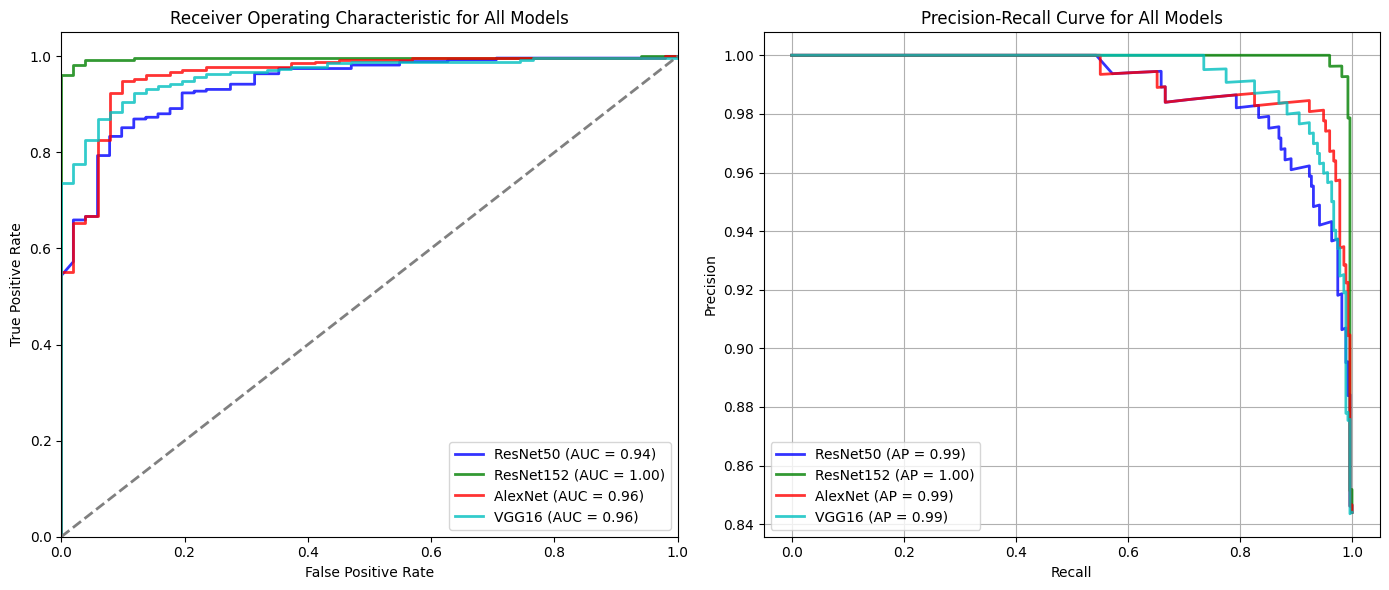

In [16]:
import matplotlib.pyplot as plt

# Improved plotting with distinct colors and thicker lines
def plot_curves(roc_curves, pr_curves):
    plt.figure(figsize=(14, 6))

    # Define colors for each model
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'lime']

    # Plot ROC Curves
    plt.subplot(1, 2, 1)
    for i, (fpr, tpr, auc_score, model_name) in enumerate(roc_curves):
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2, alpha=0.8, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for All Models')
    plt.legend(loc='lower right')

    # Plot PR Curves
    plt.subplot(1, 2, 2)
    for i, (precision, recall, auc_pr_score, model_name) in enumerate(pr_curves):
        plt.plot(recall, precision, color=colors[i % len(colors)], lw=2, alpha=0.8, label=f'{model_name} (AP = {auc_pr_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for All Models')
    plt.legend(loc='lower left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot the curves
plot_curves(roc_curves, pr_curves)

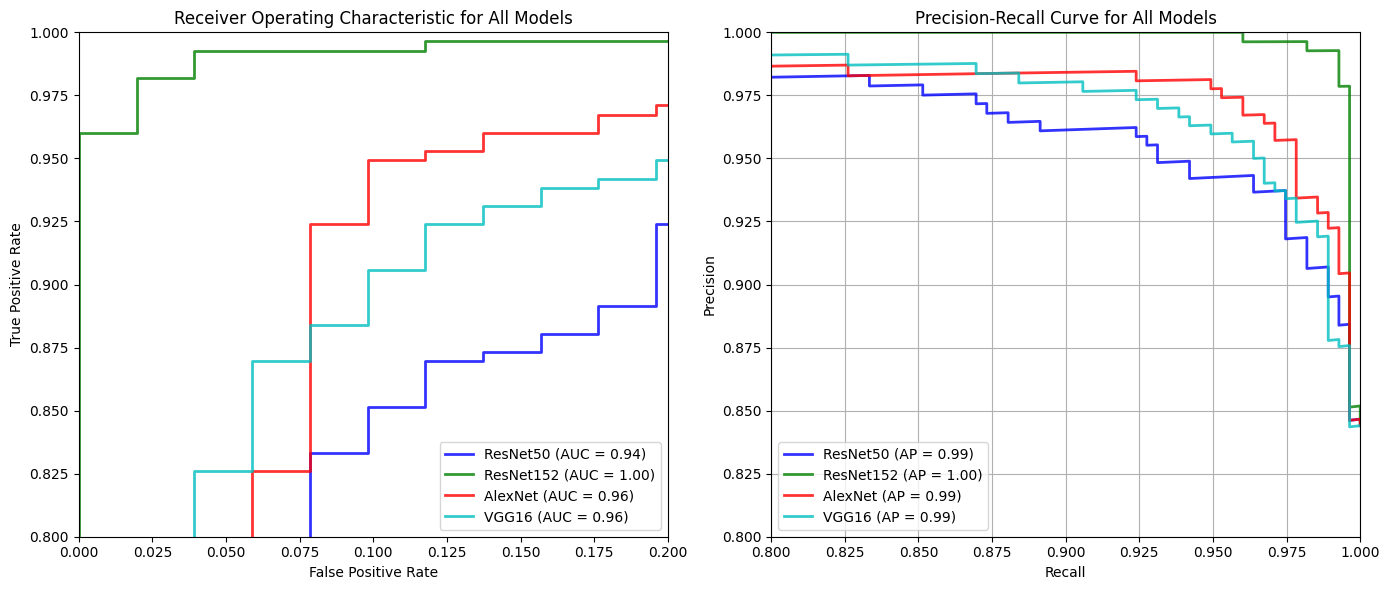

In [17]:
import matplotlib.pyplot as plt

def plot_curves(roc_curves, pr_curves):
    plt.figure(figsize=(14, 6))

    # Define colors for each model
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'lime']

    # Plot ROC Curves
    plt.subplot(1, 2, 1)
    for i, (fpr, tpr, auc_score, model_name) in enumerate(roc_curves):
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2, alpha=0.8, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 0.2])  # Zoom in on the ROC curve
    plt.ylim([0.8, 1.0])  # Adjust y-axis limits
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for All Models')
    plt.legend(loc='lower right')

    # Plot PR Curves
    plt.subplot(1, 2, 2)
    for i, (precision, recall, auc_pr_score, model_name) in enumerate(pr_curves):
        plt.plot(recall, precision, color=colors[i % len(colors)], lw=2, alpha=0.8, label=f'{model_name} (AP = {auc_pr_score:.2f})')
    plt.xlim([0.8, 1.0])  # Zoom in on the PR curve
    plt.ylim([0.8, 1.0])  # Adjust y-axis limits
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for All Models')
    plt.legend(loc='lower left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot the curves
plot_curves(roc_curves, pr_curves)
